In [186]:
from google.colab import drive
drive.mount('/content/FMAP')

Drive already mounted at /content/FMAP; to attempt to forcibly remount, call drive.mount("/content/FMAP", force_remount=True).


In [187]:
import pandas as pd
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import ScalarFormatter

### **Cargamos y observamos el dataset de entrenamiento**

In [205]:
data = pd.read_csv('/content/FMAP/MyDrive/propiedades_entrenamiento.csv', sep = ',', header=0, index_col="id")

In [206]:
data.shape


(100000, 24)

In [207]:
data.columns

Index(['ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1',
       'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

**Esquema de avisos**

*Fuente:* https://www.properati.com.ar/data

**id** - Identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja.

**ad_type** - Tipo de aviso (Propiedad, Desarrollo/Proyecto).

**start_date** - Fecha de alta del aviso.

**end_date** - Fecha de baja del aviso.

**created_on** - Fecha de alta de la primera versión del aviso.

**lat** - Latitud.

**lon** - Longitud.

**l1** - Nivel administrativo 1: país.

**l2** - Nivel administrativo 2: usualmente provincia.

**l3** - Nivel administrativo 3: usualmente ciudad.

**l4** - Nivel administrativo 4: usualmente barrio.

**rooms** - Cantidad de ambientes (útil en Argentina).

**bedrooms** - Cantidad de dormitorios (útil en el resto de los países).

**bathrooms** - Cantidad de baños.

**surface_total** - Superficie total en m².

**surface_covered** - Superficie cubierta en m².

**price** - Precio publicado en el anuncio.

**currency** - Moneda del precio publicado.

**price_period** - Periodo del precio (Diario, Semanal, Mensual)

**title** - Título del anuncio.

**description** - Descripción del anuncio.

**property_type** - Tipo de propiedad (Casa, Departamento, PH).

**operation_type** - Tipo de operación (Venta, Alquiler).

In [208]:
data.head()


,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
20dlUrbZUprl5dJqvoDFfA==,Propiedad,2021-02-05,9999-12-31,2021-02-05,-34.607055,-58.404719,Argentina,Capital Federal,Balvanera,NaN,...,1.0,NaN,NaN,110000.0,USD,NaN,Castelli 200 Balvanera 3amb U$110.000 Apto Prof,Venta de Departamento 3 AMBIENTES en Balvanera...,Departamento,Venta
NgXACOekp/hdnH/ORhrgVw==,Propiedad,2020-10-25,2021-06-08,2020-10-25,-34.590592,-58.434934,Argentina,Capital Federal,Palermo,NaN,...,2.0,137.0,137.0,340000.0,USD,Mensual,3 Amb. c/ Terraza y Sin Expensas - Palermo Soho,Espectacular Terraza con Parilla. <br>Sin Expe...,Departamento,Venta
QjKwDp+wbjTpF+7J9GQ+Kw==,Propiedad,2020-06-09,2020-08-06,2020-06-09,-34.646617,-58.520418,Argentina,Capital Federal,Liniers,NaN,...,NaN,NaN,NaN,135000.0,USD,NaN,Departamento 3 ambientes con pequeña dependenc...,Departamento 3 ambientes con peque&ntilde;a de...,Departamento,Venta
x15z5o/ettYsLrQWD2oI0w==,Propiedad,2020-05-28,2020-06-01,2020-05-28,-34.582759,-58.442774,Argentina,Capital Federal,Palermo,Palermo Hollywood,...,1.0,34.0,30.0,95878.0,USD,NaN,Departamento tipo estudio con balcón al contra...,Departamento en Arévalo Estudios Palermo Holl...,Departamento,Venta
mm5SruyPepg5TER99D0EjA==,Propiedad,2021-02-17,2021-06-17,2021-02-17,-34.576767,-58.423555,Argentina,Capital Federal,Palermo,NaN,...,2.0,85.0,85.0,NaN,NaN,Mensual,VENTA! Hermoso 3 Amb 1 Suite C/coch Full Ameni...,Ubicado entre Fray Justo Santa Maria de Oro y ...,Departamento,Venta


In [209]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 20dlUrbZUprl5dJqvoDFfA== to NoqONvxykVkmHTcaGHAqfg==
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ad_type          100000 non-null  object 
 1   start_date       100000 non-null  object 
 2   end_date         100000 non-null  object 
 3   created_on       100000 non-null  object 
 4   lat              93884 non-null   float64
 5   lon              93884 non-null   float64
 6   l1               100000 non-null  object 
 7   l2               100000 non-null  object 
 8   l3               99585 non-null   object 
 9   l4               4287 non-null    object 
 10  l5               0 non-null       float64
 11  l6               0 non-null       float64
 12  rooms            94674 non-null   float64
 13  bedrooms         82874 non-null   float64
 14  bathrooms        95216 non-null   float64
 15  surface_total    68052 non-null   float64
 16  su

In [210]:
data['ad_type'].value_counts()

Propiedad    100000
Name: ad_type, dtype: int64

In [211]:
data['property_type'].value_counts()

Departamento    90037
PH               9142
Oficina           821
Name: property_type, dtype: int64

### **Cargamos y observamos el dataset a Predecir**

In [212]:
prede = pd.read_csv('/content/FMAP/MyDrive/propiedades_a_predecir.csv',sep = ',', header=0, index_col="id" )

In [213]:
prede.shape

(1087, 27)

In [214]:
prede.columns

Index(['ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1',
       'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type', 'details',
       'additionals', 'services', 'l4', 'l5', 'l6'],
      dtype='object')

In [215]:
prede.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,...,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
id,,,,,,,,,,,,,,,,,,,,,
1,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.407908,-34.601266,Argentina,Capital Federal,Balvanera,3.0,...,Jean Jaures 700 - Departamento en Venta en Bal...,"Descripción básica:<br>- ¡Gran oportunidad, de...",Departamento,Venta,"Superficie 48.6m2, Ambientes 3, Baños 1, Dormi...","Aceptan Mascotas, Terraza","Gas, Luz",NaN,NaN,NaN
2,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.487296,-34.570272,Argentina,Capital Federal,Villa Urquiza,3.0,...,Nahuel Huapi Al 4900 - Departamento en Venta e...,Edificio de Nivel Superior en la zona! - Detal...,Departamento,Venta,"Superficie 86m2, Ambientes 3, Baños 2, Cochera...","Pileta, Seguridad, SUM, Laundry, Balcón, Terraza","Gas, Luz",NaN,NaN,NaN
3,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.414550,-34.585000,Argentina,Capital Federal,Palermo,5.0,...,Arenales Al 3700 - Departamento en Venta en Pa...,Excelente piso con palier privado y entrada de...,Departamento,Venta,"Superficie 172m2, Ambientes 5, Baños 2, Cocher...","Aceptan Mascotas, Balcón","Gas, Luz",NaN,NaN,NaN
4,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.399793,-34.600414,Argentina,Capital Federal,Balvanera,2.0,...,Pasteur 800 - Departamento en Venta en Balvane...,¡Dos ambientes con dependencia en zona Faculta...,Departamento,Venta,"Superficie 61.05m2, Ambientes 2, Baños 1, Dorm...",NaN,"Gas, Luz",NaN,NaN,NaN
5,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.426532,-34.578066,Argentina,Capital Federal,Palermo,2.0,...,Medrano Al 1200 - Departamento en Venta en Pal...,"40% de Anticipo, Saldo en 28 Cuotas<br><br>Air...",Departamento,Venta,"Superficie 52m2, Ambientes 2, Baños 2, Dormito...","Pileta, SUM, Gimnasio, Aceptan Mascotas, Terraza",NaN,NaN,NaN,NaN


In [216]:
prede.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1087 entries, 1 to 1087
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ad_type          1087 non-null   object 
 1   start_date       1087 non-null   object 
 2   end_date         1087 non-null   object 
 3   created_on       1087 non-null   object 
 4   lat              1087 non-null   float64
 5   lon              1087 non-null   float64
 6   l1               1087 non-null   object 
 7   l2               1087 non-null   object 
 8   l3               1087 non-null   object 
 9   rooms            1083 non-null   float64
 10  bedrooms         958 non-null    float64
 11  bathrooms        1083 non-null   float64
 12  surface_total    1087 non-null   float64
 13  surface_covered  1087 non-null   float64
 14  price            0 non-null      float64
 15  currency         1087 non-null   object 
 16  price_period     0 non-null      float64
 17  title         

In [217]:
prede['ad_type'].value_counts()

Propiedad    1087
Name: ad_type, dtype: int64

In [218]:
prede['property_type'].value_counts()

Departamento    823
PH              264
Name: property_type, dtype: int64

In [219]:
prede.duplicated().sum()

59

### **Limpieza de los datos**

In [220]:
# Como el dataset a predecir sólo contiene PH y Dptos vamos a eliminar las 821 Oficinas del dataset de entrenamiento

data=data[data['property_type'] != 'Oficina']
data.shape

(99179, 24)

In [221]:
data['currency'].value_counts()

USD    97498
ARS      109
Name: currency, dtype: int64

In [222]:
prede['currency'].value_counts()

USD    1087
Name: currency, dtype: int64

In [223]:
# Vemos que hay 109 propiedades en AR$ por lo que se eliminarán ya que es difícil convertir su precio a USD por los diversos tipos de cambio existentes en ARG

data=data[data['currency']=="USD"]
data.shape

(97498, 24)

In [224]:
data['currency'].value_counts()

USD    97498
Name: currency, dtype: int64

In [225]:
data.columns


Index(['ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1',
       'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

In [226]:
prede.columns


Index(['ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1',
       'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type', 'details',
       'additionals', 'services', 'l4', 'l5', 'l6'],
      dtype='object')

In [227]:
#Eliminamos las variables que a simple vista no generan valor

data.drop(['ad_type', 'start_date', 'end_date','created_on','l1','l2','l4','l5','l6','currency','price_period','title','operation_type'], axis=1, inplace=True)

data.columns


Index(['lat', 'lon', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'description', 'property_type'],
      dtype='object')

In [228]:
prede.drop(['ad_type', 'start_date', 'end_date','created_on','l1','l2','l4','l5','l6','currency','price_period','title','operation_type','details','additionals', 'services', 'l4', 'l5', 'l6'], axis=1, inplace=True)



In [229]:
prede.columns

Index(['lat', 'lon', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'description', 'property_type'],
      dtype='object')

In [230]:
data.shape  


(97498, 11)

In [231]:
prede.shape

(1087, 11)

In [232]:
# Renombramos campo l3

data.rename(columns={'l3': 'neighbourhood'}, inplace=True)
data.columns

Index(['lat', 'lon', 'neighbourhood', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'description',
       'property_type'],
      dtype='object')

In [233]:
# Renombramos campo l3 en el df a predecir

prede.rename(columns={'l3': 'neighbourhood'}, inplace=True)
prede.columns

Index(['lat', 'lon', 'neighbourhood', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'description',
       'property_type'],
      dtype='object')

In [234]:
#Vemos los NaN para proceder a trabajar sobre ellos
data.isna().sum()

lat                 5908
lon                 5908
neighbourhood        374
rooms               4704
bedrooms           16021
bathrooms           4503
surface_total      31494
surface_covered    30584
price                  0
description            0
property_type          0
dtype: int64

In [235]:
prede.isna().sum()

lat                   0
lon                   0
neighbourhood         0
rooms                 4
bedrooms            129
bathrooms             4
surface_total         0
surface_covered       0
price              1087
description           4
property_type         0
dtype: int64

In [236]:
#Se eliminan latitud y longitud NaN
data.dropna(subset=['lat', 'lon'], axis=0, inplace=True)
data.shape

(91590, 11)

In [237]:
# Se eliminan los barrios NaN

data.dropna(subset=['neighbourhood'], axis=0, inplace=True)
data.shape

(91461, 11)

In [238]:
data[data['rooms'].isnull()]

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,description,property_type
id,,,,,,,,,,,
SmfOXFj9of4TvYQqUS9s8g==,-34.570904,-58.434345,Las Cañitas,NaN,2.0,2.0,NaN,NaN,590000.0,VENDE ARQ. ALBARRACIN Propiedades . Cuba 3200 ...,Departamento
Fdj91wxriCSaUmseA3TyAQ==,-34.571888,-58.505123,Villa Urquiza,NaN,3.0,1.0,NaN,NaN,172000.0,PH Tipo Casa 4 ambientes al frente con entr...,PH
h/mnXwxWnw2cRFgVCvakjw==,-34.578964,-58.439173,Palermo,NaN,NaN,1.0,NaN,NaN,79050.0,Mood es una propuesta innovadora moderna jov...,Departamento
+pBEBBvcmzEurX0zWeUAVA==,-34.599503,-58.432285,Villa Crespo,NaN,NaN,NaN,NaN,NaN,100000.0,VENTA DE MUY LINDO DEPARTAMENTO MUY BIEN UBICA...,Departamento
aiOAel8lhXvHJVelGtdwwg==,-34.584520,-58.442273,Palermo,NaN,NaN,1.0,NaN,NaN,96999.0,Departamento - Venta - Palermo Hollywood caba...,Departamento
...,...,...,...,...,...,...,...,...,...,...,...
vmUcK4p7bRYJnaFa1GUUZQ==,-34.558788,-58.446095,Belgrano,NaN,NaN,1.0,34.0,34.0,159000.0,VENTA - A ESTRENAREDIFICIO LIBERATEUREL DEPART...,Departamento
wo9q4dlfakAA3H7GL+rxjg==,-34.566544,-58.477898,Villa Urquiza,NaN,2.0,2.0,NaN,NaN,220000.0,EMPRENDIMIENTO PH 50 - Rivera 4138 entre Plaz...,Departamento
+hKVSzYeB0XevSOx2/IyYQ==,-34.573315,-58.486809,Villa Urquiza,NaN,3.0,2.0,NaN,NaN,248000.0,Excelente departamento de estilo con tres dorm...,Departamento


In [239]:
# Se eliminan los ambientes nulos

#data.dropna(subset=['rooms'], axis=0, inplace=True)
#data.shape

In [240]:
prede[prede['rooms'].isnull()]

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,description,property_type
id,,,,,,,,,,,
107,-58.454357,-34.579236,Colegiales,NaN,1.0,1.0,27.00,27.00,NaN,Excelente monoambiente 27 metros con cocina in...,Departamento
902,-58.426532,-34.578066,Palermo,NaN,2.0,1.0,86.97,86.97,NaN,Edificio con orientación este ubicado en el Ba...,Departamento
1042,-58.464845,-34.557616,Belgrano,NaN,NaN,1.0,34.00,34.00,NaN,MONOAMBIENTE DIVISIBLE A METROS DE AV.CABILDO ...,Departamento
1080,-58.460145,-34.637484,Flores,NaN,NaN,NaN,65.00,65.00,NaN,NaN,Departamento


In [241]:
# Se imputa los ambientes vacios por el numero de habitaciones + 1
data['rooms'].fillna(data['bedrooms']+1, inplace=True)

In [242]:
prede['rooms'].fillna(prede['bedrooms']+1, inplace=True)

In [243]:
# Se imputa las habitacion NaN vacios por el numero de ambientes - 1
data['bedrooms'].fillna(data['rooms']-1, inplace=True)

In [244]:
prede['bedrooms'].fillna(prede['rooms']-1, inplace=True)

In [245]:
# Se observa si hay propiedades que tengan mas habitaciones que ambientes

data.query('bedrooms > rooms').shape

(288, 11)

In [246]:
prede.query('bedrooms > rooms').shape

(5, 11)

In [247]:
prede.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1087 entries, 1 to 1087
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              1087 non-null   float64
 1   lon              1087 non-null   float64
 2   neighbourhood    1087 non-null   object 
 3   rooms            1085 non-null   float64
 4   bedrooms         1085 non-null   float64
 5   bathrooms        1083 non-null   float64
 6   surface_total    1087 non-null   float64
 7   surface_covered  1087 non-null   float64
 8   price            0 non-null      float64
 9   description      1083 non-null   object 
 10  property_type    1087 non-null   object 
dtypes: float64(8), object(3)
memory usage: 101.9+ KB


In [248]:
# Se imputan las [habitaciones] = [ambientes - 1] en aquellos casos

data['bedrooms'] = data.apply(lambda row: row['rooms']-1 if row['bedrooms']>=row['rooms'] else row['bedrooms'], axis=1)

In [249]:
# Se imputan con [habitaciones = 0] a los monoambientes 

data['bedrooms'] = data.apply(lambda row: 0 if row['rooms'] == 1 else row['bedrooms'], axis=1)

In [250]:
prede['bedrooms'] = prede.apply(lambda row: row['rooms']-1 if row['bedrooms']>=row['rooms'] else row['bedrooms'], axis=1)
prede['bedrooms'] = prede.apply(lambda row: 0 if row['rooms'] == 1 else row['bedrooms'], axis=1)

In [251]:
prede.isna().sum()

lat                   0
lon                   0
neighbourhood         0
rooms                 2
bedrooms              2
bathrooms             4
surface_total         0
surface_covered       0
price              1087
description           4
property_type         0
dtype: int64

In [252]:
prede[prede['description'].isnull()]

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,description,property_type
id,,,,,,,,,,,
467,-58.451284,-34.552775,Belgrano,1.0,0.0,1.0,37.25,37.25,NaN,NaN,Departamento
617,-58.419221,-34.630538,Boedo,3.0,2.0,1.0,64.50,64.50,NaN,NaN,Departamento
1055,-65.217590,-26.808285,San Nicolás,2.0,1.0,1.0,35.29,35.29,NaN,NaN,Departamento
1080,-58.460145,-34.637484,Flores,NaN,NaN,NaN,65.00,65.00,NaN,NaN,Departamento


In [253]:
prede[prede['rooms'].isnull()]

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,description,property_type
id,,,,,,,,,,,
1042,-58.464845,-34.557616,Belgrano,NaN,NaN,1.0,34.0,34.0,NaN,MONOAMBIENTE DIVISIBLE A METROS DE AV.CABILDO ...,Departamento
1080,-58.460145,-34.637484,Flores,NaN,NaN,NaN,65.0,65.0,NaN,NaN,Departamento


La descripción de la fila 1042 hace referencia a un monoambiente mientras que los metros cuadrados de la prop de la fila 1080 es de 65 m2, superficie que inferimos corresponde a un 3 AMB. 

In [254]:
prede.loc[1042,['rooms']] = 1
prede.loc[1080,['rooms']] = 3
prede.loc[1042,['bedrooms']] = 0
prede.loc[1080,['bedrooms']] = 2

In [255]:
prede.sort_values(by='rooms', ascending=True).head()

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,description,property_type
id,,,,,,,,,,,
794,-58.361670,-34.815962,Palermo,0.0,-1.0,1.0,228.00,228.00,NaN,VENTA DE PH AL FRENTE DE 3 PLANTAS EN PALERMO ...,PH
453,-58.371394,-34.621835,San Telmo,1.0,0.0,1.0,35.62,35.62,NaN,Posesión Inmediata<br><br>Tras el éxito obteni...,Departamento
659,-58.448957,-34.571950,Belgrano,1.0,0.0,1.0,32.50,32.50,NaN,En el corazón de Colegiales<br>Distrito Colegi...,Departamento
892,-58.373695,-34.596986,San Nicolás,1.0,0.0,1.0,19.00,19.00,NaN,Un ambiente en el centro de Capital Federal.<b...,Departamento
464,-58.448957,-34.571950,Belgrano,1.0,0.0,1.0,32.80,32.80,NaN,En el corazón de Colegiales<br>Distrito Colegi...,Departamento


In [256]:
# Imputamos la fila con 0 amb y habitación negativa por valores coherentes que se desprenden de la descripción

prede.loc[794,['rooms']] = 6
prede.loc[794,['bedrooms']] = 5
prede.loc[794,['bathrooms']] = 3
prede.loc[[794]]

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,description,property_type
id,,,,,,,,,,,
794,-58.36167,-34.815962,Palermo,6.0,5.0,3.0,228.0,228.0,NaN,VENTA DE PH AL FRENTE DE 3 PLANTAS EN PALERMO ...,PH


In [257]:
# A los baños con NaN los imputamos con 1 ya que como minimo una vivienda debe tener un baño

data[['bathrooms']] = data[['bathrooms']].fillna(1)

In [258]:
prede[['bathrooms']] = prede[['bathrooms']].fillna(1)

In [259]:
data[(data['bathrooms']== 0)]

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,description,property_type
id,,,,,,,,,,,


In [260]:
prede[(prede['bathrooms']== 0)]

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,description,property_type
id,,,,,,,,,,,
991,-58.426446,-34.591551,Palermo,2.0,1.0,0.0,37.45,37.45,NaN,¡Dos ambientes y cocina autónoma en el barrio ...,Departamento
1003,-58.373796,-34.601860,San Nicolás,5.0,4.0,0.0,468.61,468.61,NaN,Descripción básica: <br>- Vivienda / Oficina d...,Departamento


In [261]:
# Imputamos baños con 1 y 2 en funcion de los ambientes

prede.loc[991,['bathrooms']] = 1
prede.loc[1003,['bathrooms']] = 2

In [262]:
# prede[(prede['bathrooms']== 0)]
prede.loc[991:1003,:] 

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,description,property_type
id,,,,,,,,,,,
991,-58.426446,-34.591551,Palermo,2.0,1.0,1.0,37.45,37.45,NaN,¡Dos ambientes y cocina autónoma en el barrio ...,Departamento
992,-58.405405,-34.593704,Recoleta,4.0,3.0,2.0,156.00,156.00,NaN,"Excelente Semipiso de gran categoría, muy lumi...",Departamento
993,-58.449442,-34.556264,Belgrano,3.0,2.0,1.0,72.00,72.00,NaN,"Amplio departamento de 3 ambientes, todos ello...",Departamento
994,-58.400328,-34.595596,Recoleta,4.0,3.0,2.0,104.00,104.00,NaN,PLENO RECOLETA - VENTA 3 DORMITORIOS DEPENDENC...,Departamento
995,-58.472859,-34.579047,Villa Ortuzar,3.0,2.0,1.0,70.75,70.75,NaN,Descripción básica:<br>-¡PH de 4 ambientes en ...,PH
996,-58.472890,-34.547287,Saavedra,4.0,3.0,1.0,110.00,110.00,NaN,"Entrada independiente.<br><br>PH a reciclar, g...",PH
997,-58.420118,-34.630525,Boedo,5.0,4.0,3.0,210.00,210.00,NaN,PH al fondo con entrada independiente. desarro...,PH
998,-58.466549,-34.624593,Flores,4.0,3.0,3.0,176.00,176.00,NaN,La Propiedad posee las siguientes característi...,Departamento
999,-58.505733,-34.618329,Floresta,2.0,1.0,1.0,47.10,47.10,NaN,Hermoso edificio de 5 Semipisos de 2 Ambientes...,Departamento


In [263]:
# Se eliminan las filas donde las superficies totales y cubiertas sean ambas NaN

data.dropna(subset=['surface_total','surface_covered'], how='all', axis=0, inplace=True)

In [264]:
data.shape

(64355, 11)

In [265]:
# Se observa si hay propiedades que tengan mas sup. cubierta que sup. total

data.query('surface_covered > surface_total').shape

(297, 11)

In [266]:
# Se imputan intercambiandolos

data['surface_covered'],data['surface_total'] = \
    np.where(data['surface_covered'] > data['surface_total'], \
             (data['surface_total'],data['surface_covered']), \
             (data['surface_covered'],data['surface_total']))

In [267]:
# Se verifica

data.query('surface_covered > surface_total').shape

(0, 11)

In [268]:
# Donde la sup total es NaN o Sup cubierta es NaN se imputan con los datos del otro

data['surface_total'].fillna(data['surface_covered'], inplace=True)
data['surface_covered'].fillna(data['surface_total'], inplace=True)

In [269]:
#Vemos si aún hay NaN 
data.isna().sum()

lat                   0
lon                   0
neighbourhood         0
rooms              1232
bedrooms           1232
bathrooms             0
surface_total         0
surface_covered       0
price                 0
description           0
property_type         0
dtype: int64

In [270]:
# Se eliminan los ambientes nulos

data.dropna(subset=['rooms'], axis=0, inplace=True)
data.shape

(63123, 11)

In [271]:
data.duplicated().sum()

5245

In [272]:
prede.duplicated().sum()

63

In [273]:
data.drop_duplicates(keep='first', inplace=True)

In [274]:
data.duplicated().sum()

0

In [275]:
data.shape

(57878, 11)

In [276]:
prede.isna().sum()

lat                   0
lon                   0
neighbourhood         0
rooms                 0
bedrooms              0
bathrooms             0
surface_total         0
surface_covered       0
price              1087
description           4
property_type         0
dtype: int64

In [277]:
# Se observa que los campos surface_covered y surface_total tienen los mismos valores

prede.query('surface_covered == surface_total').shape

(1087, 11)

In [278]:
data_copy=data.copy(deep=True)
prede_copy=prede.copy(deep=True)

In [279]:
# Se observa que los campos surface_covered y surface_total tienen los mismos valores

prede.query('surface_covered == surface_total').shape

(1087, 11)

In [280]:
# Nos quedamos con surface_total ya que en df a predecir muchos valores son la suma de las superficies que figuran en las descripciones

data.drop(['surface_covered'], axis=1, inplace=True)

prede.drop(['surface_covered'], axis=1, inplace=True)


In [281]:
data.columns

Index(['lat', 'lon', 'neighbourhood', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'price', 'description', 'property_type'],
      dtype='object')

In [282]:
prede.columns

Index(['lat', 'lon', 'neighbourhood', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'price', 'description', 'property_type'],
      dtype='object')

In [283]:
# Se observa que en el dataset a predecir los campos latitud y longitud estan cruzados. Se regularizan

prede.rename(columns={'lat':'lon', 'lon':'lat'}, inplace=True)

prede = prede.reindex(columns=['lat', 'lon', 'neighbourhood', 'rooms', 'bedrooms', 'bathrooms','surface_total', 'price', 'description', 'property_type'])

prede.head(10)

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,price,description,property_type
id,,,,,,,,,,
1,-34.601266,-58.407908,Balvanera,3.0,2.0,1.0,48.60,NaN,"Descripción básica:<br>- ¡Gran oportunidad, de...",Departamento
2,-34.570272,-58.487296,Villa Urquiza,3.0,2.0,2.0,86.00,NaN,Edificio de Nivel Superior en la zona! - Detal...,Departamento
3,-34.585000,-58.414550,Palermo,5.0,4.0,2.0,172.00,NaN,Excelente piso con palier privado y entrada de...,Departamento
4,-34.600414,-58.399793,Balvanera,2.0,1.0,1.0,61.05,NaN,¡Dos ambientes con dependencia en zona Faculta...,Departamento
5,-34.578066,-58.426532,Palermo,2.0,1.0,2.0,52.00,NaN,"40% de Anticipo, Saldo en 28 Cuotas<br><br>Air...",Departamento
6,-34.569399,-58.500207,Villa Urquiza,4.0,3.0,1.0,79.00,NaN,PH – 3 DORM – MUY FUNCIONAL - VILLA URQUIZA – ...,PH
7,-34.581699,-58.433547,Palermo,1.0,0.0,1.0,32.03,NaN,El emprendimiento Arévalo Estudios es un proye...,Departamento
8,-34.588529,-58.404552,Palermo,3.0,2.0,2.0,85.00,NaN,Hermoso DEPARTAMENTO de 3 ambientes con cocina...,Departamento
9,-34.551689,-58.457966,Belgrano,4.0,3.0,2.0,90.00,NaN,AMENITIES - PISCINA - PARRILLA - SUM - 3 DORMI...,Departamento


### **Unificación de Barrios**

In [284]:
barrios= data['neighbourhood'].unique()
barrios

array(['Palermo', 'Recoleta', 'Colegiales', 'Almagro', 'Villa Crespo',
       'Parque Chacabuco', 'Villa Santa Rita', 'Belgrano',
       'San Cristobal', 'Nuñez', 'Villa Urquiza', 'Retiro', 'Caballito',
       'Villa Devoto', 'Parque Centenario', 'Barrio Norte', 'Flores',
       'Villa General Mitre', 'Villa del Parque', 'Monte Castro',
       'Centro / Microcentro', 'Chacarita', 'Boedo', 'San Telmo',
       'Villa Pueyrredón', 'Floresta', 'Liniers', 'Constitución',
       'Parque Patricios', 'Saavedra', 'Barracas', 'Abasto', 'Balvanera',
       'Puerto Madero', 'Villa Luro', 'Monserrat', 'Paternal',
       'Las Cañitas', 'San Nicolás', 'Congreso', 'Mataderos',
       'Villa Lugano', 'Coghlan', 'Velez Sarsfield', 'Versalles',
       'Tribunales', 'Pompeya', 'Boca', 'Villa Ortuzar',
       'Parque Avellaneda', 'Agronomía', 'Parque Chas', 'Once',
       'Villa Real', 'Catalinas', 'Villa Soldati', 'Villa Riachuelo'],
      dtype=object)

Se consulta en https://www.buenosaires.gob.ar/laciudad/barrios por sus verdaderos nombres. En total existen 48. Se reemplazan los "ficticios" por los correctos y se corrigen los nombres de otros.

In [285]:
data['neighbourhood'].replace({'Abasto': 'Almagro','Barrio Norte':'Recoleta','Catalinas':'Retiro', 'Centro / Microcentro':'San Nicolás', 'Congreso': 'Balvanera', 'Las Cañitas':'Palermo', 'Once':'Balvanera', 'Parque Centenario': 'Caballito', 'San Nicolas': 'San Nicolás','Tribunales': 'San Nicolás', 'Boca':'La Boca', 'Paternal':'La Paternal','Pompeya': 'Nueva Pompeya' ,'Villa Ortuzar':'Villa Ortúzar','Villa Pueyrredon':'Villa Pueyrredón','Velez Sarsfield': 'Vélez Sarsfield'},inplace=True)

In [286]:
barrios2= data['neighbourhood'].unique()
barrios2

array(['Palermo', 'Recoleta', 'Colegiales', 'Almagro', 'Villa Crespo',
       'Parque Chacabuco', 'Villa Santa Rita', 'Belgrano',
       'San Cristobal', 'Nuñez', 'Villa Urquiza', 'Retiro', 'Caballito',
       'Villa Devoto', 'Flores', 'Villa General Mitre',
       'Villa del Parque', 'Monte Castro', 'San Nicolás', 'Chacarita',
       'Boedo', 'San Telmo', 'Villa Pueyrredón', 'Floresta', 'Liniers',
       'Constitución', 'Parque Patricios', 'Saavedra', 'Barracas',
       'Balvanera', 'Puerto Madero', 'Villa Luro', 'Monserrat',
       'La Paternal', 'Mataderos', 'Villa Lugano', 'Coghlan',
       'Vélez Sarsfield', 'Versalles', 'Nueva Pompeya', 'La Boca',
       'Villa Ortúzar', 'Parque Avellaneda', 'Agronomía', 'Parque Chas',
       'Villa Real', 'Villa Soldati', 'Villa Riachuelo'], dtype=object)

In [287]:
barrios3= prede['neighbourhood'].unique()
barrios3

array(['Balvanera', 'Villa Urquiza', 'Palermo', 'Belgrano', 'Floresta',
       'Villa Pueyrredon', 'Saavedra', 'Villa Devoto', 'San Nicolás',
       'Chacarita', 'Villa Crespo', 'Boedo', 'Flores', 'Paternal', 'Boca',
       'Recoleta', 'Caballito', 'Nuñez', 'Constitución', 'Colegiales',
       'San Telmo', 'Monserrat', 'Puerto Madero', 'Villa del Parque',
       'Almagro', 'Villa Ortuzar', 'Villa Lugano', 'San Cristobal',
       'Barracas', 'Liniers', '2 Ambientes', 'Mataderos',
       'Villa Santa Rita', 'Parque Patricios', 'Parque Chas',
       'Villa General Mitre', 'Retiro', 'Parque Avellaneda',
       'Monte Castro', 'Parque Chacabuco', 'Villa Luro', 'Versalles',
       'Coghlan', 'Vélez Sarsfield', 'Nueva Pompeya', 'Agronomía',
       'Villa Real', 'GBA Norte'], dtype=object)

In [288]:
prede[(prede['neighbourhood']=='2 Ambientes') | (prede['neighbourhood']=='GBA Norte')]

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,price,description,property_type
id,,,,,,,,,,
133,-34.589963,-58.434555,2 Ambientes,2.0,1.0,1.0,51.0,NaN,Descripción básica: <br>- PH 2 ambientes de 50...,PH
1010,-34.544037,-58.510875,GBA Norte,6.0,4.0,3.0,265.0,NaN,"Vivienda multifamiliar con deposito , galpon, ...",PH


In [289]:
prede['neighbourhood'].replace({'Abasto': 'Almagro','Barrio Norte':'Recoleta','Catalinas':'Retiro', 'Centro / Microcentro':'San Nicolás', 'Congreso': 'Balvanera', 'Las Cañitas':'Palermo', 'Once':'Balvanera', 'Parque Centenario': 'Caballito', 'San Nicolas': 'San Nicolás','Tribunales': 'San Nicolás', 'Boca':'La Boca', 'Paternal':'La Paternal','Villa Ortuzar':'Villa Ortúzar','Velez Sarsfield': 'Vélez Sarsfield', 'Villa Pueyrredon':'Villa Pueyrredón' ,'GBA Norte':'Saavedra', '2 Ambientes': 'Palermo'},inplace=True)

In [290]:
barrios4= prede['neighbourhood'].unique()
barrios4

array(['Balvanera', 'Villa Urquiza', 'Palermo', 'Belgrano', 'Floresta',
       'Villa Pueyrredón', 'Saavedra', 'Villa Devoto', 'San Nicolás',
       'Chacarita', 'Villa Crespo', 'Boedo', 'Flores', 'La Paternal',
       'La Boca', 'Recoleta', 'Caballito', 'Nuñez', 'Constitución',
       'Colegiales', 'San Telmo', 'Monserrat', 'Puerto Madero',
       'Villa del Parque', 'Almagro', 'Villa Ortúzar', 'Villa Lugano',
       'San Cristobal', 'Barracas', 'Liniers', 'Mataderos',
       'Villa Santa Rita', 'Parque Patricios', 'Parque Chas',
       'Villa General Mitre', 'Retiro', 'Parque Avellaneda',
       'Monte Castro', 'Parque Chacabuco', 'Villa Luro', 'Versalles',
       'Coghlan', 'Vélez Sarsfield', 'Nueva Pompeya', 'Agronomía',
       'Villa Real'], dtype=object)

In [291]:
# Eliminamos Villa Riachuelo y Villa Soldati del Df de entrenamiento ya que no figuran en el de predecir

data=data[data['neighbourhood'] != 'Villa Soldati']
data=data[data['neighbourhood'] != 'Villa Riachuelo']

In [292]:
barrios5= data['neighbourhood'].unique()
barrios5

array(['Palermo', 'Recoleta', 'Colegiales', 'Almagro', 'Villa Crespo',
       'Parque Chacabuco', 'Villa Santa Rita', 'Belgrano',
       'San Cristobal', 'Nuñez', 'Villa Urquiza', 'Retiro', 'Caballito',
       'Villa Devoto', 'Flores', 'Villa General Mitre',
       'Villa del Parque', 'Monte Castro', 'San Nicolás', 'Chacarita',
       'Boedo', 'San Telmo', 'Villa Pueyrredón', 'Floresta', 'Liniers',
       'Constitución', 'Parque Patricios', 'Saavedra', 'Barracas',
       'Balvanera', 'Puerto Madero', 'Villa Luro', 'Monserrat',
       'La Paternal', 'Mataderos', 'Villa Lugano', 'Coghlan',
       'Vélez Sarsfield', 'Versalles', 'Nueva Pompeya', 'La Boca',
       'Villa Ortúzar', 'Parque Avellaneda', 'Agronomía', 'Parque Chas',
       'Villa Real'], dtype=object)

In [293]:
#set_difference = set(data['neighbourhood'].unique()) - set(prede['neighbourhood'].unique())
#list_difference = list(set_difference)
#print('Barrios diferentes:', list_difference)

### **Análisis Exploratorio**

In [294]:
import matplotlib.pyplot as plt



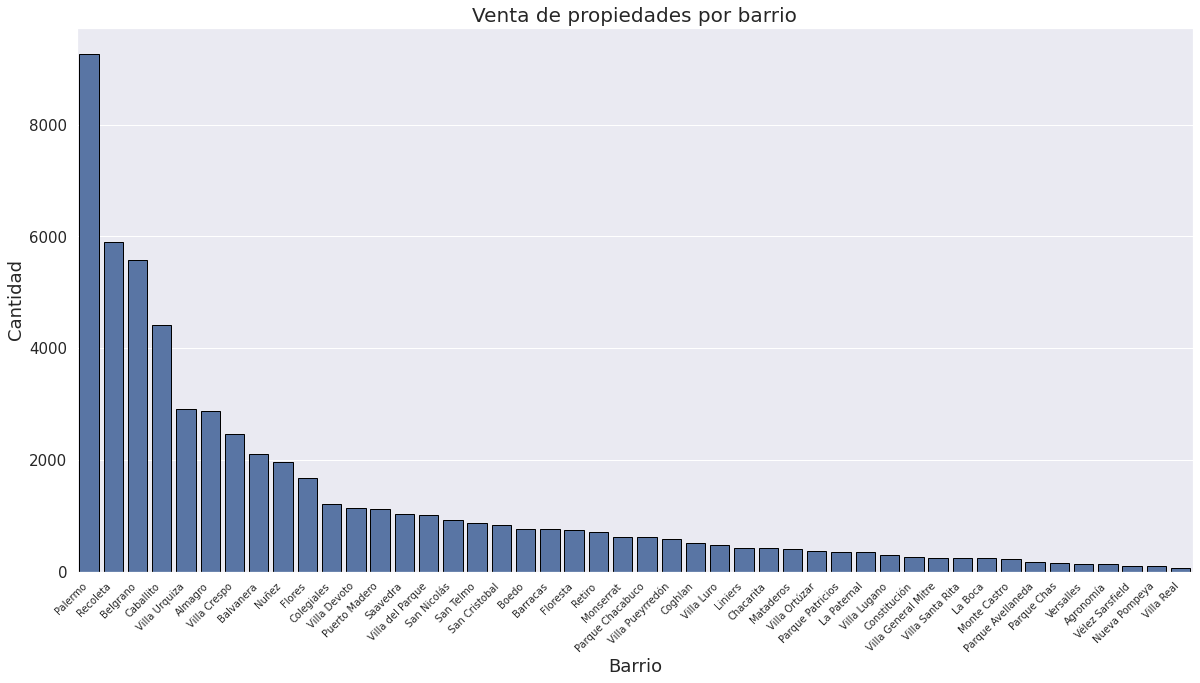

In [295]:
plt.figure(figsize=(20,10))
sns.set(font_scale=2)
ax = sns.countplot(data=data,x="neighbourhood",order=data["neighbourhood"].value_counts().index, color="b", ec='black')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",fontsize=10)
plt.yticks(fontsize=15)
ax.set_title("Venta de propiedades por barrio", fontsize=20)
ax.set_xlabel("Barrio", fontsize=18)
ax.set_ylabel("Cantidad", fontsize=18)
plt.show()

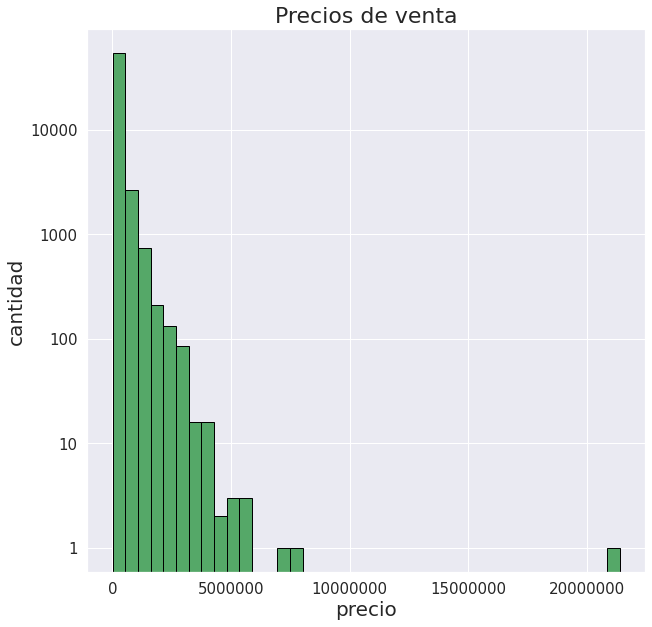

In [296]:
plt.figure(figsize=(10,10))
plt.hist(data['price'], bins=40, color='g', ec='black')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Precios de venta", fontsize=22)
plt.xlabel('precio', fontsize=20)
plt.ylabel('cantidad', fontsize=20)
plt.ticklabel_format(style='plain', axis='x')
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.show()

In [297]:
data.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,lat,lon,rooms,bedrooms,bathrooms,surface_total,price
count,57832.00000,57832.00000,57832.00000,57832.00000,57832.00000,57832.00000,57832.00000
mean,-34.59557,-58.43699,2.67592,1.60907,1.42962,112.65396,229805.62341
std,0.02551,0.03764,1.32534,1.19672,0.75877,1165.04964,299414.38116
min,-34.69409,-58.53039,1.00000,0.00000,1.00000,1.00000,5000.00000
25%,-34.61417,-58.46376,2.00000,1.00000,1.00000,44.00000,100000.00000
50%,-34.59523,-58.43732,3.00000,2.00000,1.00000,64.00000,149900.00000
75%,-34.57767,-58.40806,3.00000,2.00000,2.00000,98.00000,245000.00000
max,-34.53600,-58.34395,35.00000,34.00000,18.00000,125000.00000,21400000.00000


In [298]:
prede.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,lat,lon,rooms,bedrooms,bathrooms,surface_total,price
count,1087.00000,1087.00000,1087.00000,1087.00000,1087.00000,1087.00000,0.00000
mean,-34.46455,-58.22478,2.84177,1.76449,1.42042,89.93023,nan
std,2.98726,5.02220,1.49732,1.35561,0.75611,76.68783,nan
min,-38.01520,-65.21759,1.00000,0.00000,1.00000,16.62000,nan
25%,-34.61480,-58.45797,2.00000,1.00000,1.00000,42.24500,nan
50%,-34.59596,-58.43381,3.00000,2.00000,1.00000,66.00000,nan
75%,-34.57891,-58.40939,4.00000,2.00000,2.00000,102.00000,nan
max,34.81900,58.59400,13.00000,10.00000,7.00000,551.52000,nan


Text(0.5, 1.0, 'Correlación Entramiento')

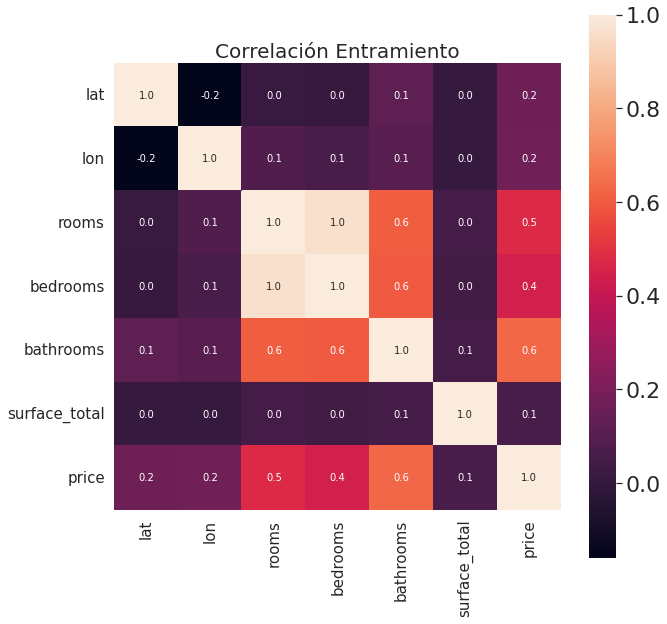

In [299]:
corr = data.corr()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':10})
plt.title("Correlación Entramiento", fontsize=20)

Text(0.5, 1.0, 'Correlación a Predecir')

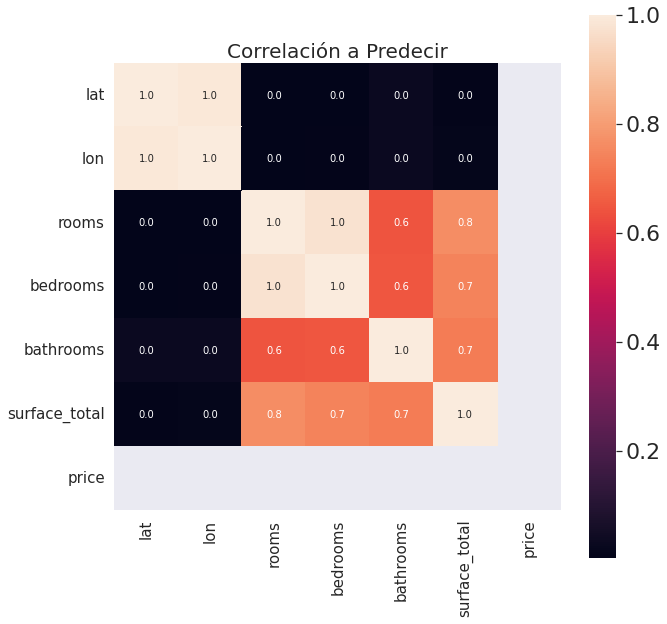

In [300]:
corr = prede.corr()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':10})
plt.title("Correlación a Predecir", fontsize=20)

In [301]:
# filtramos las variables numéricas

var_num = [feature for feature in data.columns if (data[feature].dtypes != 'O')]
print('Total de variables numéricas: ', len(var_num))

Total de variables numéricas:  7


In [302]:
data[var_num].head(10)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,price
id,,,,,,,
NgXACOekp/hdnH/ORhrgVw==,-34.590592,-58.434934,3.0,2.0,2.0,137.0,340000.0
x15z5o/ettYsLrQWD2oI0w==,-34.582759,-58.442774,1.0,0.0,1.0,34.0,95878.0
F9yD+Rb8jXYsxZ8q6zCZRg==,-34.595293,-58.410646,3.0,2.0,1.0,6429.0,159900.0
abSxa7LmpHyvrLoTsN2DoQ==,-34.579104,-58.438894,2.0,1.0,1.0,50.0,150000.0
wT2N/xBfYiTD0ViFqchbEQ==,-34.572507,-58.447047,3.0,2.0,1.0,65.0,180100.0
PHHcxu+Oi1XKc/H2xnLiOQ==,-34.616321,-58.415597,2.0,1.0,1.0,51.0,98000.0
ciCSk8md3dUb/Hh8FooPwA==,-34.565904,-58.434880,4.0,3.0,1.0,92.0,250000.0
5fcxKp569pjWqNPJEL0v+g==,-34.586263,-58.443766,4.0,3.0,2.0,134.0,295240.0
5nUURRMXUUIXTyTMvXIp5A==,-34.587940,-58.396316,2.0,1.0,1.0,30.0,75000.0


In [303]:
var_num2 = [feature for feature in prede.columns if (prede[feature].dtypes != 'O')]
print('Total de variables numéricas df a predecir: ', len(var_num))

Total de variables numéricas df a predecir:  7


In [304]:
prede[var_num2].head(10)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,price
id,,,,,,,
1,-34.601266,-58.407908,3.0,2.0,1.0,48.60,NaN
2,-34.570272,-58.487296,3.0,2.0,2.0,86.00,NaN
3,-34.585000,-58.414550,5.0,4.0,2.0,172.00,NaN
4,-34.600414,-58.399793,2.0,1.0,1.0,61.05,NaN
5,-34.578066,-58.426532,2.0,1.0,2.0,52.00,NaN
6,-34.569399,-58.500207,4.0,3.0,1.0,79.00,NaN
7,-34.581699,-58.433547,1.0,0.0,1.0,32.03,NaN
8,-34.588529,-58.404552,3.0,2.0,2.0,85.00,NaN
9,-34.551689,-58.457966,4.0,3.0,2.0,90.00,NaN


In [305]:
# vemos cuantas de ellas son discretas

#var_disc=[feature for feature in var_num if len(data[feature].unique())<25]
#print("Total variables discretas: {}".format(len(var_disc)))

In [306]:
# vemos cuantas de ellas son continuas

#var_cont=[feature for feature in var_num if feature not in var_disc]
#print("Total variables continuas: {}".format(len(var_cont)))

In [307]:
# graficamos las distribuciones continuas

#data[var_disc].hist(figsize=(10,10))
#plt.xticks(fontsize=10)
#plt.yticks(fontsize=10);

In [308]:
#plt.figure(figsize=(20,60), facecolor='white')
#plotnumber =2
#for continuous_feature in var_cont2:
    #ax = plt.subplot(12,3,plotnumber)
    #sns.distplot(data[continuous_feature])
    #plt.xticks(fontsize=15)
    #plt.yticks(fontsize=15)
    #plt.ylabel('Densidad',fontsize=15)
    #plt.xlabel([continuous_feature],fontsize=10)
    #plotnumber+=1
#plt.show()

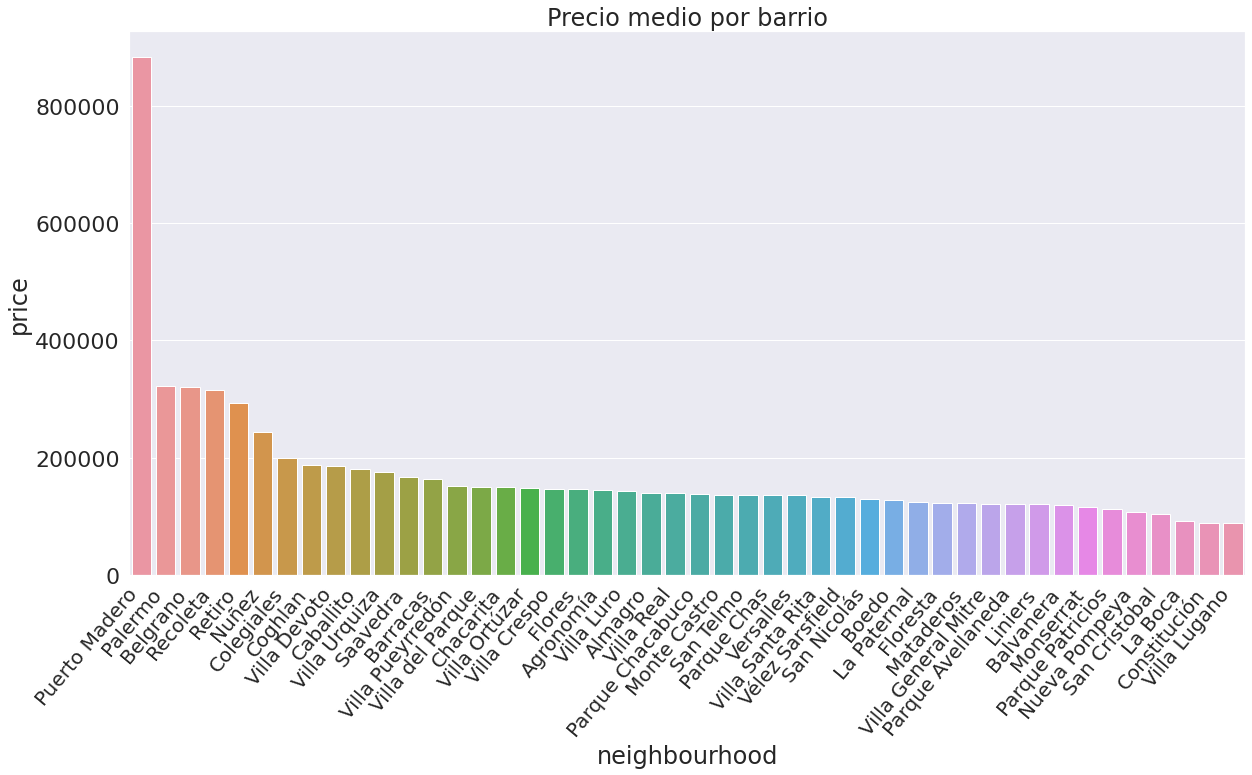

In [309]:
# Media de precios por barrio

neighbourhood_mean = data.groupby(by='neighbourhood').mean()

plt.figure(figsize=(20,10))
ax = sns.barplot(x = neighbourhood_mean.index, y = neighbourhood_mean["price"], order=neighbourhood_mean.sort_values('price', ascending=False).index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=50,ha="right",fontsize=20)
plt.title("Precio medio por barrio")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


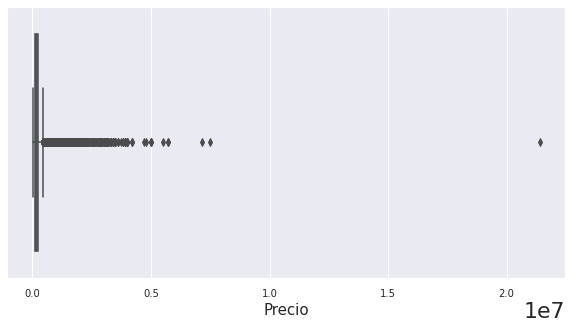

In [310]:
plt.figure(figsize=(10,5))
sns.boxplot(data['price'])
plt.xlabel('Precio',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [311]:
#data.groupby(['neighbourhood'])['price'].max().sort_values(ascending=False)

In [312]:
data.shape

(57832, 10)

In [313]:
#####Limitamos precios entre 25000 USD(precio bajo en barrio más barato) y 4000000 (precio más alto en barrio más caro)
data = data[(data['price']>26000) & (data['price']<4000000)]

In [314]:
data.shape

(57752, 10)

In [315]:
for i in range(0, 100, 10):
    var =data["price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 27000.0
10 percentile value is 77000.0
20 percentile value is 93349.0
30 percentile value is 110001.0
40 percentile value is 129000.0
50 percentile value is 149900.0
60 percentile value is 176800.0
70 percentile value is 218000.0
80 percentile value is 279900.0
90 percentile value is 420000.0
100 percentile value is  3900000.0


In [316]:
for i in range(90, 100, 1):
    var =data["price"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 420000.0
91 percentile value is 450000.0
92 percentile value is 480000.0
93 percentile value is 520000.0
94 percentile value is 570000.0
95 percentile value is 635000.0
96 percentile value is 720000.0
97 percentile value is 849000.0
98 percentile value is 1100000.0
99 percentile value is 1480000.0
100 percentile value is  3900000.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


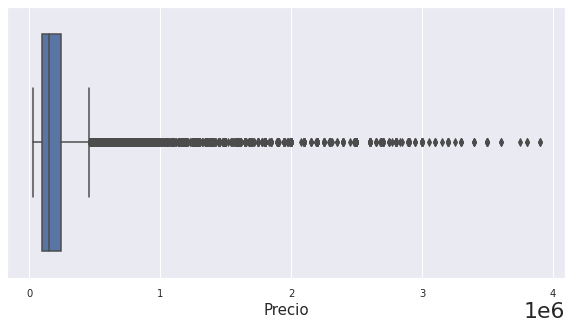

In [317]:
plt.figure(figsize=(10,5))
sns.boxplot(data['price'])
plt.xlabel('Precio',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

<Figure size 576x432 with 0 Axes>

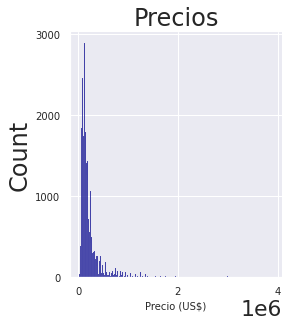

In [318]:
###graficamos para ver la nueva distribucion:
plt.figure(figsize=(8,6))
sns.displot(data=data['price'], color='darkblue').set(title='Precios')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Precio (US$)', fontsize=10);

In [319]:
###
data['price'].describe()

count    5.775200e+04
mean     2.279952e+05
std      2.721251e+05
min      2.700000e+04
25%      1.000000e+05
50%      1.499000e+05
75%      2.450000e+05
max      3.900000e+06
Name: price, dtype: float64

In [320]:
#####

data.groupby(['neighbourhood'])['price'].mean().sort_values(ascending=False)

neighbourhood
Puerto Madero          863863.889388
Palermo                319690.662092
Belgrano               318475.357642
Recoleta               311249.153520
Retiro                 293226.778711
Nuñez                  240969.065540
Colegiales             199161.978636
Coghlan                187884.637255
Villa Devoto           186457.230228
Caballito              176700.492632
Villa Urquiza          175339.954577
Saavedra               166931.542553
Barracas               164151.231176
Villa Pueyrredón       151181.001727
Villa del Parque       150246.151426
Chacarita              149661.348235
Villa Ortúzar          148114.013298
Villa Crespo           147313.175560
Flores                 146655.041317
Agronomía              144325.050725
Villa Luro             143831.781053
Almagro                140120.832119
Villa Real             140048.181818
Parque Chacabuco       138817.895765
Monte Castro           136915.090129
San Telmo              136604.888889
Parque Chas            1

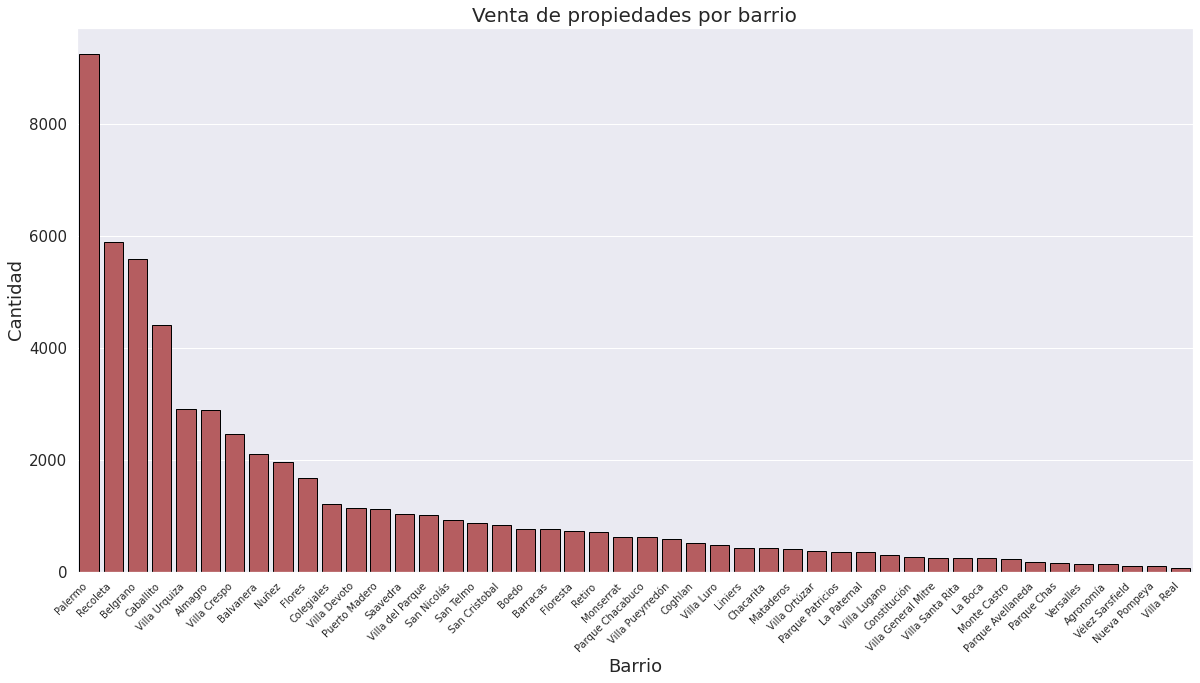

In [321]:
plt.figure(figsize=(20,10))
sns.set(font_scale=2)
ax = sns.countplot(data=data,x="neighbourhood",order=data["neighbourhood"].value_counts().index, color="r", ec='black')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",fontsize=10)
plt.yticks(fontsize=15)
ax.set_title("Venta de propiedades por barrio", fontsize=20)
ax.set_xlabel("Barrio", fontsize=18)
ax.set_ylabel("Cantidad", fontsize=18)
plt.show()

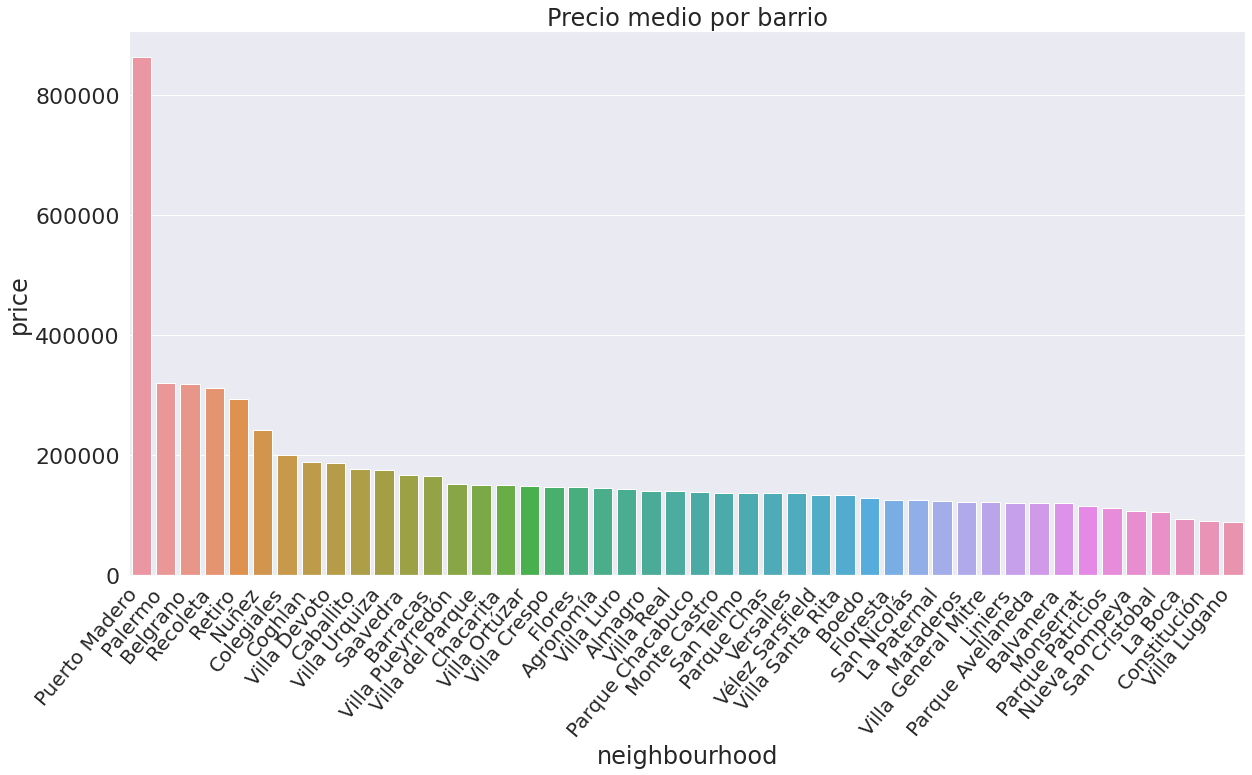

In [322]:
# Media de precios por barrio

neighbourhood_mean = data.groupby(by='neighbourhood').mean()
plt.figure(figsize=(20,10))
ax = sns.barplot(x = neighbourhood_mean.index, y = neighbourhood_mean["price"], order=neighbourhood_mean.sort_values('price', ascending=False).index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=50,ha="right",fontsize=20)
plt.title("Precio medio por barrio")
plt.show()

In [323]:
### DEscribe del grafico

data['price'].describe()

count    5.775200e+04
mean     2.279952e+05
std      2.721251e+05
min      2.700000e+04
25%      1.000000e+05
50%      1.499000e+05
75%      2.450000e+05
max      3.900000e+06
Name: price, dtype: float64

### **Superficie**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


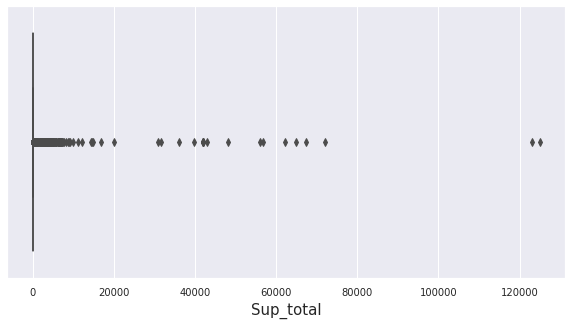

In [324]:
plt.figure(figsize=(10,5))
sns.boxplot(data['surface_total'])
plt.xlabel('Sup_total',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [325]:
######

data[var_num].sort_values(by='surface_total', ascending=False).head(20)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,price
id,,,,,,,
JRQNzOSQN5giRSH5mOY+lQ==,-34.609821,-58.392606,4.0,3.0,1.0,125000.0,255000.0
sF6mHw2pmSGo3IPjC1lJJw==,-34.569963,-58.481658,3.0,2.0,2.0,123000.0,194000.0
WQU6YIN+y4z30xaPRG4LHQ==,-34.636532,-58.376406,4.0,3.0,1.0,72060.0,210000.0
vuTcF89mt6AZGGsSxIsS1Q==,-34.628114,-58.525157,3.0,2.0,1.0,67350.0,138000.0
qLC4I45gTS2gy5KzUzBifQ==,-34.563814,-58.457204,3.0,2.0,1.0,64800.0,230000.0
07nsQt7NwnmcTysOzZ3xnQ==,-34.558880,-58.462844,3.0,2.0,1.0,62100.0,165000.0
+YPtNPAzbhoDCLgqF26Q8A==,-34.587320,-58.401556,2.0,1.0,1.0,56740.0,175000.0
EY6Jqtz2w01CqVwivx9Zdw==,-34.603312,-58.495545,3.0,2.0,1.0,55960.0,150000.0
eitRFwSNlqOoSB7n+owt/Q==,-34.620495,-58.413706,2.0,1.0,1.0,48170.0,133000.0


In [326]:
####



In [327]:
#####

data['surface_total'].describe()

count     57752.000000
mean        112.597451
std        1165.833472
min           1.000000
25%          44.000000
50%          64.000000
75%          98.000000
max      125000.000000
Name: surface_total, dtype: float64

In [328]:
#####

prede['surface_total'].describe()

count    1087.000000
mean       89.930230
std        76.687828
min        16.620000
25%        42.245000
50%        66.000000
75%       102.000000
max       551.520000
Name: surface_total, dtype: float64

In [329]:
#####Limitamos el trainset a los valores min y max del testset
data= data[(data['surface_total']>16) & (data['surface_total']<552)]

In [330]:
data.shape

(57467, 10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


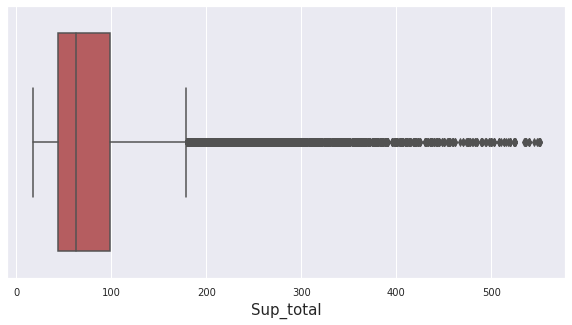

In [331]:
plt.figure(figsize=(10,5))
sns.boxplot(data['surface_total'], color = 'r')
plt.xlabel('Sup_total',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### **Ambientes**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


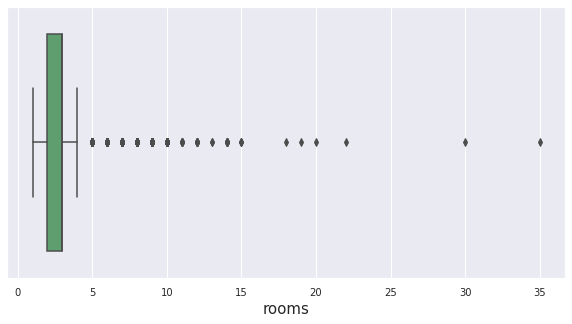

In [332]:
plt.figure(figsize=(10,5))
sns.boxplot(data['rooms'], color = 'g')
plt.xlabel('rooms',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [333]:
prede['rooms'].describe()

count    1087.000000
mean        2.841766
std         1.497322
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        13.000000
Name: rooms, dtype: float64

In [334]:
data['rooms'].describe()

count    57467.000000
mean         2.671672
std          1.302498
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         35.000000
Name: rooms, dtype: float64

In [335]:
data = data[data['rooms']<=13]

In [336]:
data['rooms'].describe()

count    57448.000000
mean         2.666829
std          1.270869
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         13.000000
Name: rooms, dtype: float64

### ***Habitaciones***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


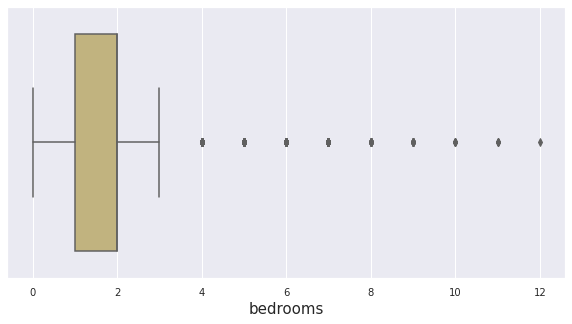

In [337]:
plt.figure(figsize=(10,5))
sns.boxplot(data['bedrooms'], color = 'y')
plt.xlabel('bedrooms',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [338]:
prede['bedrooms'].describe()

count    1087.000000
mean        1.764489
std         1.355607
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        10.000000
Name: bedrooms, dtype: float64

In [339]:
data['bedrooms'].describe()

count    57448.000000
mean         1.602841
std          1.158000
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         12.000000
Name: bedrooms, dtype: float64

### ***Baños/Bathrooms***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


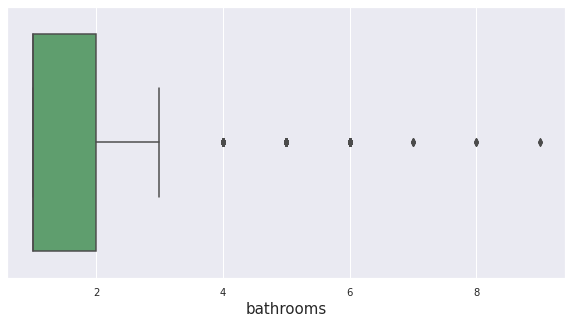

In [340]:
plt.figure(figsize=(10,5))
sns.boxplot(data['bathrooms'], color = 'g')
plt.xlabel('bathrooms',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [341]:
prede['bathrooms'].describe()

count    1087.000000
mean        1.420423
std         0.756109
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: bathrooms, dtype: float64

In [342]:
data['bathrooms'].describe()

count    57448.000000
mean         1.425254
std          0.743134
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: bathrooms, dtype: float64

In [343]:
prede.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1087 entries, 1 to 1087
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lat            1087 non-null   float64
 1   lon            1087 non-null   float64
 2   neighbourhood  1087 non-null   object 
 3   rooms          1087 non-null   float64
 4   bedrooms       1087 non-null   float64
 5   bathrooms      1087 non-null   float64
 6   surface_total  1087 non-null   float64
 7   price          0 non-null      float64
 8   description    1083 non-null   object 
 9   property_type  1087 non-null   object 
dtypes: float64(7), object(3)
memory usage: 93.4+ KB


### ***One-hot encoding para property_type***

In [344]:
data = pd.get_dummies(data, columns=["property_type"])
data.head()

,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,price,description,property_type_Departamento,property_type_PH
id,,,,,,,,,,,
NgXACOekp/hdnH/ORhrgVw==,-34.590592,-58.434934,Palermo,3.0,2.0,2.0,137.0,340000.0,Espectacular Terraza con Parilla. <br>Sin Expe...,1,0
x15z5o/ettYsLrQWD2oI0w==,-34.582759,-58.442774,Palermo,1.0,0.0,1.0,34.0,95878.0,Departamento en Arévalo Estudios Palermo Holl...,1,0
abSxa7LmpHyvrLoTsN2DoQ==,-34.579104,-58.438894,Palermo,2.0,1.0,1.0,50.0,150000.0,DEPARTAMENTO DE DOS AMBIENTES EN PALERMO CON A...,1,0
wT2N/xBfYiTD0ViFqchbEQ==,-34.572507,-58.447047,Colegiales,3.0,2.0,1.0,65.0,180100.0,Cercana a medios de transportes y paseos comer...,1,0
PHHcxu+Oi1XKc/H2xnLiOQ==,-34.616321,-58.415597,Almagro,2.0,1.0,1.0,51.0,98000.0,Excelente y amplio 2 ambientes al frente. <br>...,1,0


In [350]:
prede = pd.get_dummies(prede, columns=["property_type"])
prede.head()

KeyError: ignored

In [346]:
#Guardamos (PINZAS)
data.to_csv("/content/FMAP/MyDrive/data_semilimpio1.csv")

prede.to_csv("/content/FMAP/MyDrive/prede_semilimpio1.csv")

In [486]:
data.head()

,id,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,price,description,property_type_Departamento,property_type_PH
0,1,-34.59,-58.43,21,3.00,2.00,2.00,137.00,340000.00,Espectacular Terraza con Parilla. <br>Sin Expe...,1,0
1,2,-34.58,-58.44,21,1.00,0.00,1.00,34.00,95878.00,Departamento en Arévalo Estudios Palermo Holl...,1,0
2,3,-34.58,-58.44,21,2.00,1.00,1.00,50.00,150000.00,DEPARTAMENTO DE DOS AMBIENTES EN PALERMO CON A...,1,0
3,4,-34.57,-58.45,11,3.00,2.00,1.00,65.00,180100.00,Cercana a medios de transportes y paseos comer...,1,0
4,5,-34.62,-58.42,2,2.00,1.00,1.00,51.00,98000.00,Excelente y amplio 2 ambientes al frente. <br>...,1,0


In [364]:
data.reset_index (drop = True , inplace = True )
prede.reset_index (drop = True , inplace = True )

In [367]:
data['id']=np.arange(1,len(data)+1)
prede['id']=np.arange(1,len(prede)+1)

In [360]:
data.columns


Index(['lat', 'lon', 'neighbourhood', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'price', 'description', 'property_type_Departamento',
       'property_type_PH', 'id'],
      dtype='object')

In [369]:
data=data.reindex(columns=['id','lat', 'lon', 'neighbourhood', 'rooms', 'bedrooms', 'bathrooms','surface_total', 'price', 'description', 'property_type_Departamento', 'property_type_PH'])
prede=prede.reindex(columns=['id','lat', 'lon', 'neighbourhood', 'rooms', 'bedrooms', 'bathrooms','surface_total', 'price', 'description', 'property_type_Departamento', 'property_type_PH'])

In [375]:
data.head()

,id,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,price,description,property_type_Departamento,property_type_PH
0,1,-34.590592,-58.434934,21,3.0,2.0,2.0,137.0,340000.0,Espectacular Terraza con Parilla. <br>Sin Expe...,1,0
1,2,-34.582759,-58.442774,21,1.0,0.0,1.0,34.0,95878.0,Departamento en Arévalo Estudios Palermo Holl...,1,0
2,3,-34.579104,-58.438894,21,2.0,1.0,1.0,50.0,150000.0,DEPARTAMENTO DE DOS AMBIENTES EN PALERMO CON A...,1,0
3,4,-34.572507,-58.447047,11,3.0,2.0,1.0,65.0,180100.0,Cercana a medios de transportes y paseos comer...,1,0
4,5,-34.616321,-58.415597,2,2.0,1.0,1.0,51.0,98000.0,Excelente y amplio 2 ambientes al frente. <br>...,1,0


In [374]:
# Encoding barrios

data['neighbourhood'].replace({"Agronomía":1, "Almagro":2, "Balvanera":3,"Barracas":4,"Belgrano":5,"La Boca": 6, "Boedo":7,"Caballito":8,"Chacarita":9,"Coghlan":10,"Colegiales":11,"Constitución":12,"Flores":13,"Floresta":14, "Liniers":15, "Mataderos":16,"Monserrat":17,"Monte Castro":18,"Nueva Pompeya":19,"Nuñez":20,"Palermo":21,"Parque Avellaneda":22,"Parque Chacabuco":23,"Parque Chas":24,"Parque Patricios":25,"La Paternal":26, "Puerto Madero":27, "Recoleta":28,"Retiro":29,"Saavedra":30,"San Cristobal":31,"San Nicolás":32,"San Telmo":33,"Versalles":34,"Villa Crespo":35,"Villa Devoto":36,"Villa General Mitre":37,"Villa Lugano":38, "Villa Luro":39, "Villa Ortúzar":40,"Villa Pueyrredón":41,"Villa Real":42,"Villa Santa Rita":43,"Villa Urquiza":44,"Villa del Parque":45,"Vélez Sarsfield":46} ,inplace = True)

TypeError: ignored

In [379]:
alfa=data['neighbourhood'].unique()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57448 entries, 0 to 57447
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          57448 non-null  int64  
 1   lat                         57448 non-null  float64
 2   lon                         57448 non-null  float64
 3   neighbourhood               57448 non-null  int64  
 4   rooms                       57448 non-null  float64
 5   bedrooms                    57448 non-null  float64
 6   bathrooms                   57448 non-null  float64
 7   surface_total               57448 non-null  float64
 8   price                       57448 non-null  float64
 9   description                 57448 non-null  object 
 10  property_type_Departamento  57448 non-null  uint8  
 11  property_type_PH            57448 non-null  uint8  
dtypes: float64(7), int64(2), object(1), uint8(2)
memory usage: 4.5+ MB


In [383]:
data.head()

,id,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,price,description,property_type_Departamento,property_type_PH
0,1,-34.590592,-58.434934,21,3.0,2.0,2.0,137.0,340000.0,Espectacular Terraza con Parilla. <br>Sin Expe...,1,0
1,2,-34.582759,-58.442774,21,1.0,0.0,1.0,34.0,95878.0,Departamento en Arévalo Estudios Palermo Holl...,1,0
2,3,-34.579104,-58.438894,21,2.0,1.0,1.0,50.0,150000.0,DEPARTAMENTO DE DOS AMBIENTES EN PALERMO CON A...,1,0
3,4,-34.572507,-58.447047,11,3.0,2.0,1.0,65.0,180100.0,Cercana a medios de transportes y paseos comer...,1,0
4,5,-34.616321,-58.415597,2,2.0,1.0,1.0,51.0,98000.0,Excelente y amplio 2 ambientes al frente. <br>...,1,0


In [380]:
prede['neighbourhood'].replace({"Agronomía":1, "Almagro":2, "Balvanera":3,"Barracas":4,"Belgrano":5,"La Boca": 6, "Boedo":7,"Caballito":8,"Chacarita":9,"Coghlan":10,"Colegiales":11,"Constitución":12,"Flores":13,"Floresta":14, "Liniers":15, "Mataderos":16,"Monserrat":17,"Monte Castro":18,"Nueva Pompeya":19,"Nuñez":20,"Palermo":21,"Parque Avellaneda":22,"Parque Chacabuco":23,"Parque Chas":24,"Parque Patricios":25,"La Paternal":26, "Puerto Madero":27, "Recoleta":28,"Retiro":29,"Saavedra":30,"San Cristobal":31,"San Nicolás":32,"San Telmo":33,"Versalles":34,"Villa Crespo":35,"Villa Devoto":36,"Villa General Mitre":37,"Villa Lugano":38, "Villa Luro":39, "Villa Ortúzar":40,"Villa Pueyrredón":41,"Villa Real":42,"Villa Santa Rita":43,"Villa Urquiza":44,"Villa del Parque":45,"Vélez Sarsfield":46} ,inplace = True)

In [384]:
prede.head()

,id,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,price,description,property_type_Departamento,property_type_PH
0,1,-34.601266,-58.407908,3,3.0,2.0,1.0,48.60,NaN,"Descripción básica:<br>- ¡Gran oportunidad, de...",1,0
1,2,-34.570272,-58.487296,44,3.0,2.0,2.0,86.00,NaN,Edificio de Nivel Superior en la zona! - Detal...,1,0
2,3,-34.585000,-58.414550,21,5.0,4.0,2.0,172.00,NaN,Excelente piso con palier privado y entrada de...,1,0
3,4,-34.600414,-58.399793,3,2.0,1.0,1.0,61.05,NaN,¡Dos ambientes con dependencia en zona Faculta...,1,0
4,5,-34.578066,-58.426532,21,2.0,1.0,2.0,52.00,NaN,"40% de Anticipo, Saldo en 28 Cuotas<br><br>Air...",1,0


In [174]:
#prede=prede.astype('float64')

ValueError: ignored

*** ### AUTO ML ### ***

In [156]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [459]:
import numpy as np
from sklearn.model_selection import train_test_split

In [460]:
entrenamiento = data.loc[:, ['id','lat', 'lon', 'neighbourhood', 'rooms', 'bedrooms', 'bathrooms','surface_total', 'price', 'property_type_Departamento', 'property_type_PH']]

In [461]:
test =prede.loc[:, ['id','lat', 'lon', 'neighbourhood', 'rooms', 'bedrooms', 'bathrooms','surface_total', 'price', 'property_type_Departamento', 'property_type_PH']]

In [458]:
entrenamiento=entrenamiento.astype('float64')
test=test.astype('float64')

In [462]:
entrenamiento.dtypes

id                              int64
lat                           float64
lon                           float64
neighbourhood                   int64
rooms                         float64
bedrooms                      float64
bathrooms                     float64
surface_total                 float64
price                         float64
property_type_Departamento      uint8
property_type_PH                uint8
dtype: object

In [463]:
test.dtypes

id                              int64
lat                           float64
lon                           float64
neighbourhood                   int64
rooms                         float64
bedrooms                      float64
bathrooms                     float64
surface_total                 float64
price                         float64
property_type_Departamento      uint8
property_type_PH                uint8
dtype: object

In [399]:
train = entrenamiento[:25000]
train.head(100)

,id,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,price,property_type_Departamento,property_type_PH
0,1.0,-34.590592,-58.434934,21.0,3.0,2.0,2.0,137.0,340000.0,1.0,0.0
1,2.0,-34.582759,-58.442774,21.0,1.0,0.0,1.0,34.0,95878.0,1.0,0.0
2,3.0,-34.579104,-58.438894,21.0,2.0,1.0,1.0,50.0,150000.0,1.0,0.0
3,4.0,-34.572507,-58.447047,11.0,3.0,2.0,1.0,65.0,180100.0,1.0,0.0
4,5.0,-34.616321,-58.415597,2.0,2.0,1.0,1.0,51.0,98000.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
95,96.0,-34.577448,-58.424296,21.0,3.0,2.0,1.0,70.0,330000.0,1.0,0.0
96,97.0,-34.561996,-58.461147,5.0,2.0,1.0,3.0,74.0,274000.0,1.0,0.0
97,98.0,-34.577160,-58.439481,21.0,2.0,1.0,1.0,39.0,190000.0,1.0,0.0
98,99.0,-34.624380,-58.374254,33.0,2.0,1.0,1.0,51.0,142000.0,1.0,0.0


In [464]:
test.head(10)

,id,lat,lon,neighbourhood,rooms,bedrooms,bathrooms,surface_total,price,property_type_Departamento,property_type_PH
0,1,-34.60,-58.41,3,3.00,2.00,1.00,48.60,nan,1,0
1,2,-34.57,-58.49,44,3.00,2.00,2.00,86.00,nan,1,0
2,3,-34.59,-58.41,21,5.00,4.00,2.00,172.00,nan,1,0
3,4,-34.60,-58.40,3,2.00,1.00,1.00,61.05,nan,1,0
4,5,-34.58,-58.43,21,2.00,1.00,2.00,52.00,nan,1,0
5,6,-34.57,-58.50,44,4.00,3.00,1.00,79.00,nan,0,1
6,7,-34.58,-58.43,21,1.00,0.00,1.00,32.03,nan,1,0
7,8,-34.59,-58.40,21,3.00,2.00,2.00,85.00,nan,1,0
8,9,-34.55,-58.46,5,4.00,3.00,2.00,90.00,nan,1,0
9,10,-34.62,-58.49,14,5.00,3.00,1.00,128.00,nan,0,1


In [465]:
# Se particionan los datos en un conjunto de entrenamiento que contiene el 80% de los datos y en un conjunto de testeo con el 20% restante
# además de separar la variable a predecir para cada caso
X_train, X_test, y_train, y_test = train_test_split(train.drop(['price'], axis=1), train['price'],test_size=.2,random_state =42)

In [466]:
import lazypredict
from lazypredict.Supervised import LazyRegressor #se eligen los modelos de regresión
from sklearn.utils import shuffle

In [404]:
# Construcción y entrenamiento de los modelos
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None, predictions=True)
models_test,predictions_test = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [09:14<00:00, 13.19s/it]


In [467]:
# Resultados en Testing de la performance del modelo
models_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.88,0.88,98438.26,2.41
HistGradientBoostingRegressor,0.88,0.88,100813.27,0.98
RandomForestRegressor,0.87,0.87,101276.70,10.24
LGBMRegressor,0.87,0.87,101491.60,0.38
ExtraTreesRegressor,0.87,0.87,103232.02,5.49
BaggingRegressor,0.85,0.86,108919.43,1.07
GradientBoostingRegressor,0.85,0.85,110390.36,3.28
KNeighborsRegressor,0.79,0.79,131637.18,0.43
ExtraTreeRegressor,0.75,0.75,143548.55,0.14


In [468]:
#En que librerías se encuentran los modelos implementados?
reg.regressors

[('AdaBoostRegressor', sklearn.ensemble._weight_boosting.AdaBoostRegressor),
 ('BaggingRegressor', sklearn.ensemble._bagging.BaggingRegressor),
 ('BayesianRidge', sklearn.linear_model._bayes.BayesianRidge),
 ('DecisionTreeRegressor', sklearn.tree._classes.DecisionTreeRegressor),
 ('DummyRegressor', sklearn.dummy.DummyRegressor),
 ('ElasticNet', sklearn.linear_model._coordinate_descent.ElasticNet),
 ('ElasticNetCV', sklearn.linear_model._coordinate_descent.ElasticNetCV),
 ('ExtraTreeRegressor', sklearn.tree._classes.ExtraTreeRegressor),
 ('ExtraTreesRegressor', sklearn.ensemble._forest.ExtraTreesRegressor),
 ('GammaRegressor', sklearn.linear_model._glm.glm.GammaRegressor),
 ('GaussianProcessRegressor',
  sklearn.gaussian_process._gpr.GaussianProcessRegressor),
 ('GeneralizedLinearRegressor',
  sklearn.linear_model._glm.glm.GeneralizedLinearRegressor),
 ('GradientBoostingRegressor', sklearn.ensemble._gb.GradientBoostingRegressor),
 ('HistGradientBoostingRegressor',
  sklearn.ensemble._hi

In [406]:
#obtención de los parámetros utilizados 
reg.models['RandomForestRegressor']  #muestra el pipeline que utiliza

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['id', 'lat', 'lon', 'neighbourhood', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'property_type_Departamento', 'property_type_PH'],
      dtype='object')),
                                                 ('categorical_low',
                                                  Pipeline(steps=[('imputer',
                                                                   Si...value='missing',
                                                                                 strategy='constant')),
           

***IMPLEMENTACION MODELO ***

In [469]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale 
xtrain, xtest, ytrain, ytest = train_test_split(entrenamiento.drop(['price'], axis=1), entrenamiento['price'],test_size=.2,random_state =42)
                             

dtr =RandomForestRegressor(random_state=42) # utilizando el mismo parámetro
dtr.fit(xtrain, ytrain)

RandomForestRegressor(random_state=42)

**Predicción y Performance**

In [470]:
#se obtienen las predicciones
ypred = dtr.predict(xtest)

In [471]:
#se calcula el RMSE
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, ypred, squared=False)

89745.89617485556

In [472]:
#se calcula el R-Squared
from sklearn.metrics import r2_score
r2_score(ytest, ypred, multioutput='variance_weighted')

0.8903684239047098

**Optimización Parámetros**

In [411]:
#obtener los parámetros de un modelo
dtr.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [415]:
#seteamos valores para algunos de los parámetros
parameters = {
    'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
    'max_features':[1,5,10,20,30,40,50], 
    'min_samples_split':[2,3,4,5,6]
}

In [416]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from typing import Tuple, List, Any, Dict

def fit_and_optimize(X_train_data: np.ndarray, X_test_data: np.ndarray, y_train_data: np.ndarray, y_test_data: np.ndarray, 
                       model: Any, param_grid: Dict[str, Any], cv: int=5, scoring_fit: str='neg_mean_squared_error') -> Tuple[Any, np.ndarray]:
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, #deafult 5
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [417]:
#buscamos la mejor combinación de parámetros
search, predictions = fit_and_optimize(xtrain, xtest, ytrain, ytest, dtr, parameters, cv=5)
#importante: usar cross validation (CV) para evitar overfitting

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 82.1min
[Parallel(n_jobs=-1)]: Done 1925 out of 1925 | elapsed: 109.1min finished


In [473]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

print(search.best_params_) #devuelve la mejor combinación de parámetros obtenida anteriormente
print(f"MAE: {mean_absolute_error(ypred, ytest):.3f}")
print(f"MSE: {mean_squared_error(ypred, ytest, squared=False):.3f}")
print(f"R2: {r2_score(ypred, ytest):.3f}")

{'max_depth': 50, 'max_features': 5, 'min_samples_split': 2}
MAE: 38725.373
MSE: 89745.896
R2: 0.882


**Obtención y Visualización de los resultados**

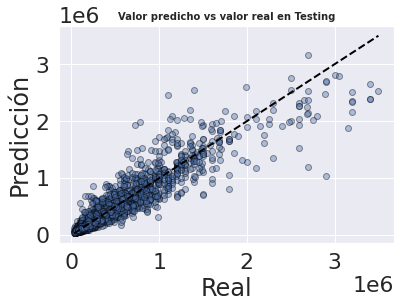

In [474]:
#ploteo predicción obtenida vs verdaderos valores en Testing
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(ytest, ypred, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()],'k--', color = 'black', lw=2)
plt.title('Valor predicho vs valor real en Testing', fontsize = 10, fontweight = "bold")
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.show()

In [475]:
#ante la imposibilidad de leer los resultados, primero se obtiene la importancia de las variables
for name, importance in zip(entrenamiento.drop(['price'], axis=1).columns, dtr.feature_importances_):
    print(name + ': ' + str(importance.round(2)))

id: 0.02
lat: 0.11
lon: 0.11
neighbourhood: 0.01
rooms: 0.01
bedrooms: 0.01
bathrooms: 0.03
surface_total: 0.63
property_type_Departamento: 0.03
property_type_PH: 0.03


In [476]:
#Armamos un data frame 
importancia_predictores = pd.DataFrame(
                            {'predictor': entrenamiento.drop(['price'], axis=1).columns, 
                             'importancia': dtr.feature_importances_}
                            ).sort_values('importancia', ascending=False)
importancia_predictores

,predictor,importancia
7,surface_total,0.63
2,lon,0.11
1,lat,0.11
9,property_type_PH,0.03
8,property_type_Departamento,0.03
6,bathrooms,0.03
0,id,0.02
3,neighbourhood,0.01
4,rooms,0.01
5,bedrooms,0.01


Text(0.5, 1.0, 'Importancia de las variables')

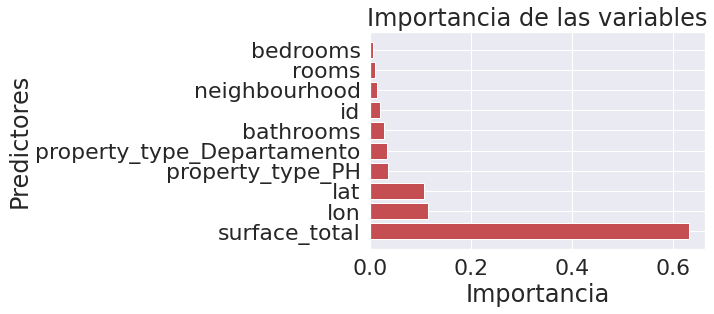

In [477]:
#Graficamos range(cant de variables)

import matplotlib.pyplot as plt
plt.barh(range(10),importancia_predictores['importancia'], color ='r') #aca el problema era el range. Antes decía 25, pero vos ahora tenes 12 variables.
plt.yticks(range(10),importancia_predictores['predictor'], rotation=360) #aca el problema era el range. Antes decía 25, pero vos ahora tenes 12 variables.
plt.xlabel("Importancia")
plt.ylabel("Predictores")
plt.title("Importancia de las variables")

In [478]:
#se seleccionan las variables de mayor importancia
entrenamiento2=entrenamiento[['id','price','surface_total', 'bathrooms', 'lat', 'lon', 'property_type_Departamento','property_type_PH']]

In [479]:
#nos quedamos con las predictoras más importantes y tratamos de re estimar el modelo para ver si alcanza una performance similar

xtrain, xtest, ytrain, ytest = train_test_split(entrenamiento2.drop('price', axis=1), entrenamiento2['price'],test_size=.2,random_state =42)

In [480]:
#re estimación del modelo
dtr2 = RandomForestRegressor(max_depth=50, max_features=5,  random_state=42)
dtr2.fit(xtrain, ytrain)
ypred = dtr2.predict(xtest)
r2_score(ytest, ypred, multioutput='variance_weighted')

0.8873942105681576

Prediccion del Testing

In [481]:
#seleccionamos las mismas varibles que en entrenamiento2 pero SIN PRICE

test1=test.loc[:, ['id','lat', 'lon', 'bathrooms','surface_total', 'property_type_Departamento', 'property_type_PH']]

In [482]:
test1

,id,lat,lon,bathrooms,surface_total,property_type_Departamento,property_type_PH
0,1,-34.60,-58.41,1.00,48.60,1,0
1,2,-34.57,-58.49,2.00,86.00,1,0
2,3,-34.59,-58.41,2.00,172.00,1,0
3,4,-34.60,-58.40,1.00,61.05,1,0
4,5,-34.58,-58.43,2.00,52.00,1,0
...,...,...,...,...,...,...,...
1082,1083,-34.61,-58.40,1.00,36.85,1,0
1083,1084,-34.60,-58.40,1.00,51.61,1,0
1084,1085,-34.59,-58.40,1.00,98.00,1,0
1085,1086,-34.62,-58.51,1.00,45.50,1,0


In [483]:
test1.isnull().sum()

id                            0
lat                           0
lon                           0
bathrooms                     0
surface_total                 0
property_type_Departamento    0
property_type_PH              0
dtype: int64

In [484]:
#se obtienen las predicciones aplicando el modelo sobre el dataset predicciones = test1
ypred_final = dtr2.predict(test1)   #o dtr2.predict? el re estimado?

In [485]:
prediccion1=pd.DataFrame()
prediccion1['id']=test1['id']
prediccion1['price']=ypred_final
prediccion1

,id,price
0,1,136271.99
1,2,136271.99
2,3,136271.99
3,4,136271.99
4,5,136271.99
...,...,...
1082,1083,135591.99
1083,1084,135591.99
1084,1085,135591.99
1085,1086,135591.99


In [437]:
prediccion1.to_csv("/content/FMAP/MyDrive/soluprueba.csv", index=False)